<a href="https://colab.research.google.com/github/Saher-Amasha/face-detection-and-facial-recognition-in-pytorch/blob/main/hw4_saher_amasha_207607136_safa_amasha_211941943.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/timesler/facenet-pytorch

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1267, done.
remote: Total 1267 (delta 0), reused 0 (delta 0), pack-reused 1267
Receiving objects: 100% (1267/1267), 22.88 MiB | 23.81 MiB/s, done.
Resolving deltas: 100% (619/619), done.


In [2]:
# With pip:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 6.7 MB/s 


In [3]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [5]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [6]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [7]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('/content/facenet-pytorch/data/test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Face detected with probability: 0.999983
Face detected with probability: 0.999934
Face detected with probability: 0.999733
Face detected with probability: 0.999880
Face detected with probability: 0.999992


In [9]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

In [10]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

                angelina_jolie  bradley_cooper  kate_siegel  paul_rudd  \
angelina_jolie        0.000000        1.447480     0.887728   1.429847   
bradley_cooper        1.447480        0.000000     1.313749   1.013447   
kate_siegel           0.887728        1.313749     0.000000   1.388377   
paul_rudd             1.429847        1.013447     1.388377   0.000000   
shea_whigham          1.399073        1.038684     1.379654   1.100503   

                shea_whigham  
angelina_jolie      1.399073  
bradley_cooper      1.038684  
kate_siegel         1.379654  
paul_rudd           1.100503  
shea_whigham        0.000000  


In [11]:
from IPython.display import Image
import requests # to get image from the web
import shutil # to save it locally

## Set up the image URL and filename
image_url = "https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fstatic.onecms.io%2Fwp-content%2Fuploads%2Fsites%2F6%2F2018%2F09%2Fgordon-ramsay-hells-kitchen-02-2000.jpg&q=60"
filename = 'img1.png'

# Open the url image, set stream to True, this will return the stream content.
r = requests.get(image_url, stream = True)

# Check if the image was retrieved successfully
if r.status_code == 200:
    # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
    r.raw.decode_content = True
    
    # Open a local file with wb ( write binary ) permission.
    with open(filename,'wb') as f:
        shutil.copyfileobj(r.raw, f)
        
    print('Image sucessfully Downloaded: ',filename)
else:
    print('Image Couldn\'t be retreived')

Image sucessfully Downloaded:  img1.png


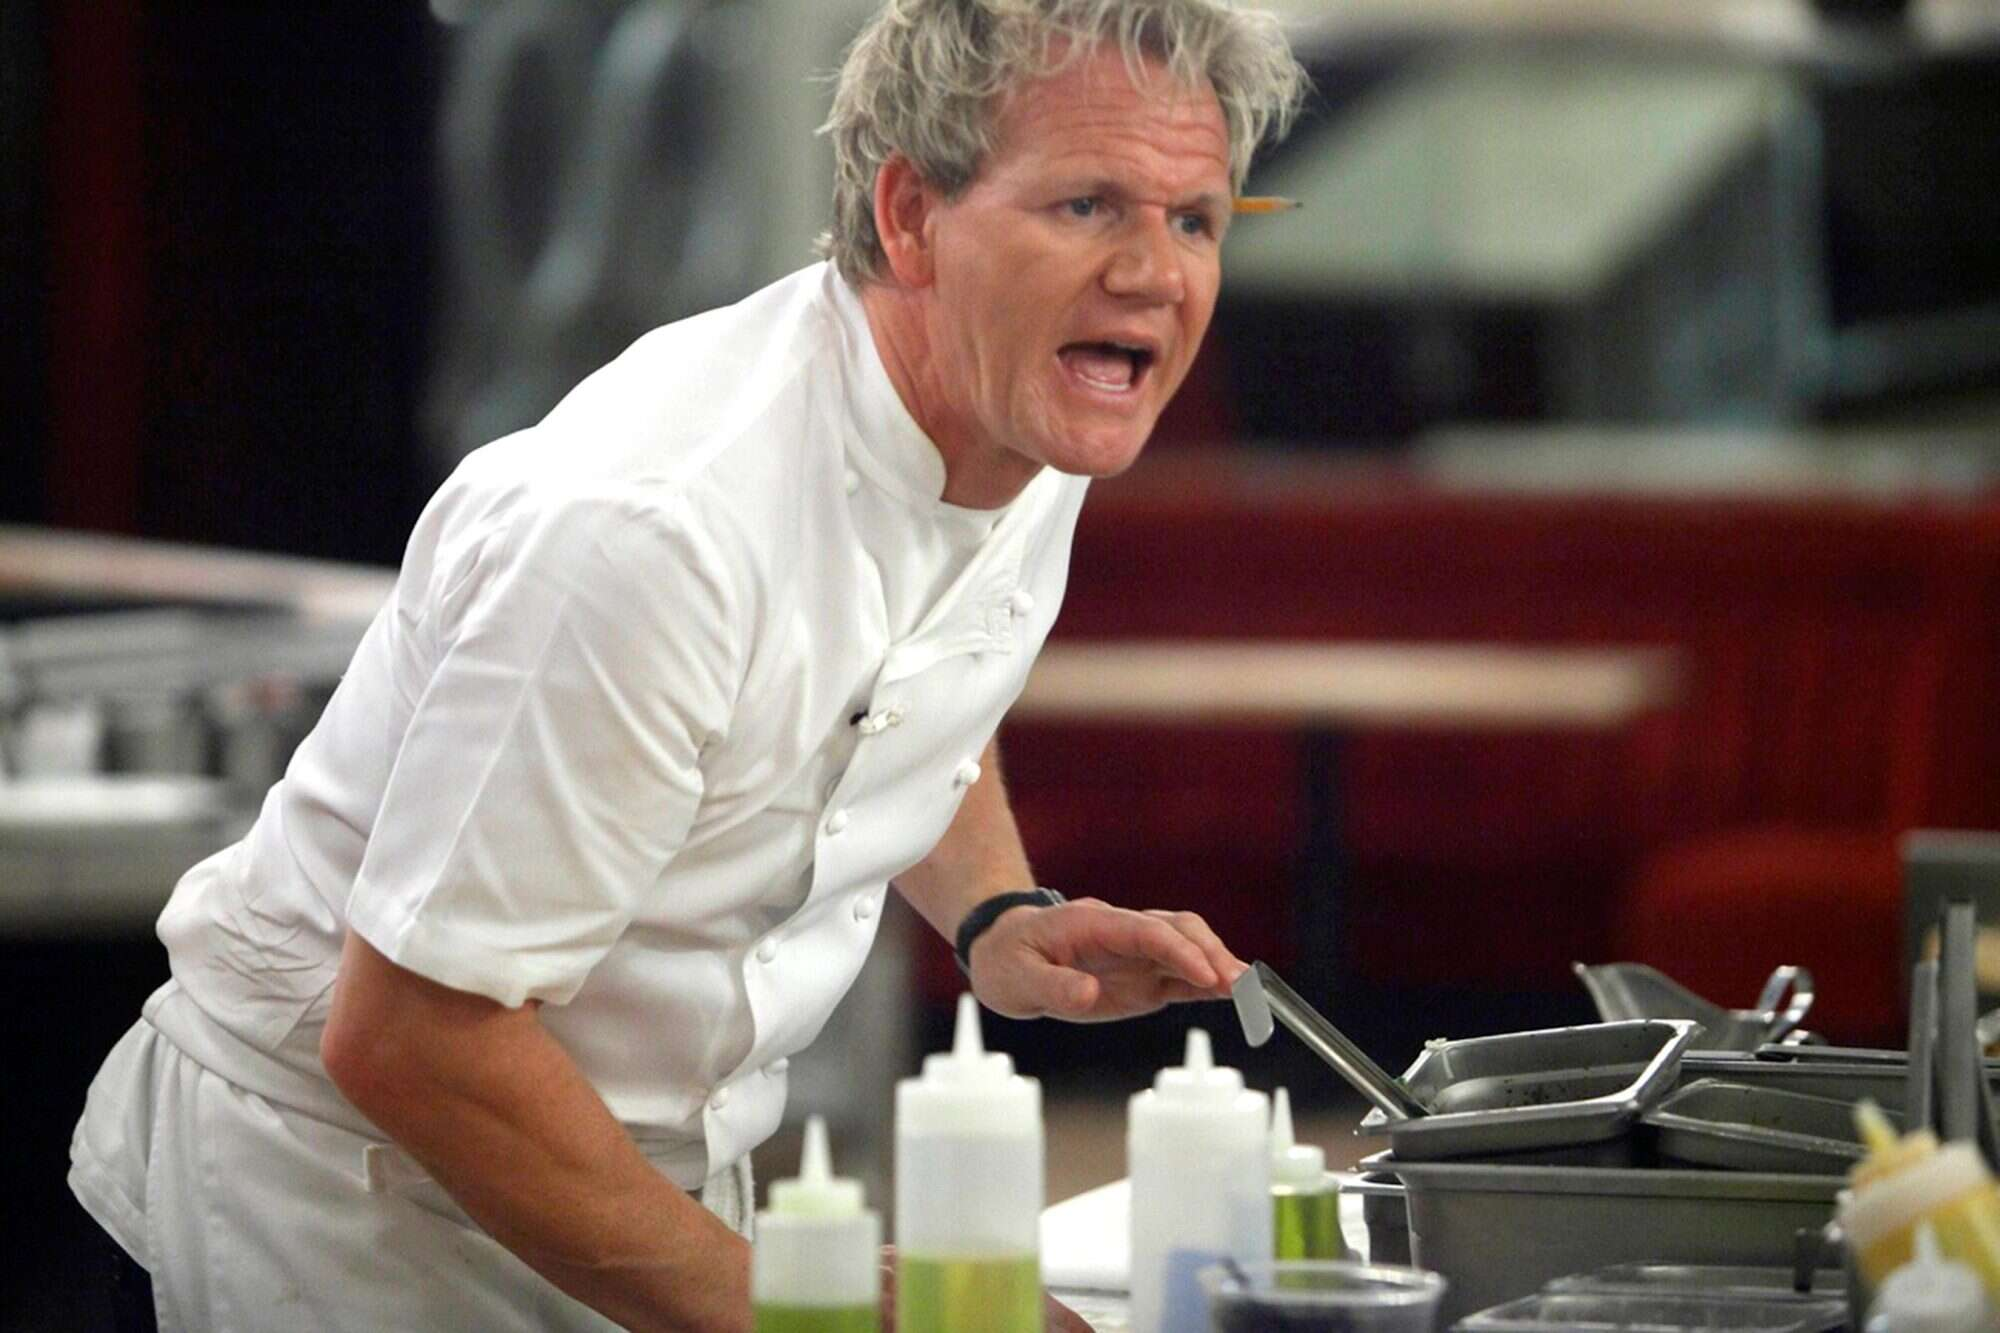

In [12]:
Image('img1.png')

In [13]:
from facenet_pytorch import MTCNN, InceptionResnetV1

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=2000, margin=500)

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()

In [14]:
from PIL import Image

img = Image.open('/content/img1.png')

# Get cropped and prewhitened image tensor
img_cropped = mtcnn(img, save_path='/content/img1_done.png')

# Calculate embedding (unsqueeze to add batch dimension)
resnet.classify = True
img_probs = resnet(img_cropped.unsqueeze(0))
print(img_probs)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


tensor([[-0.8586, -0.6486, -0.2298,  ...,  0.8230,  1.2863,  0.2785]],
       grad_fn=<AddmmBackward0>)


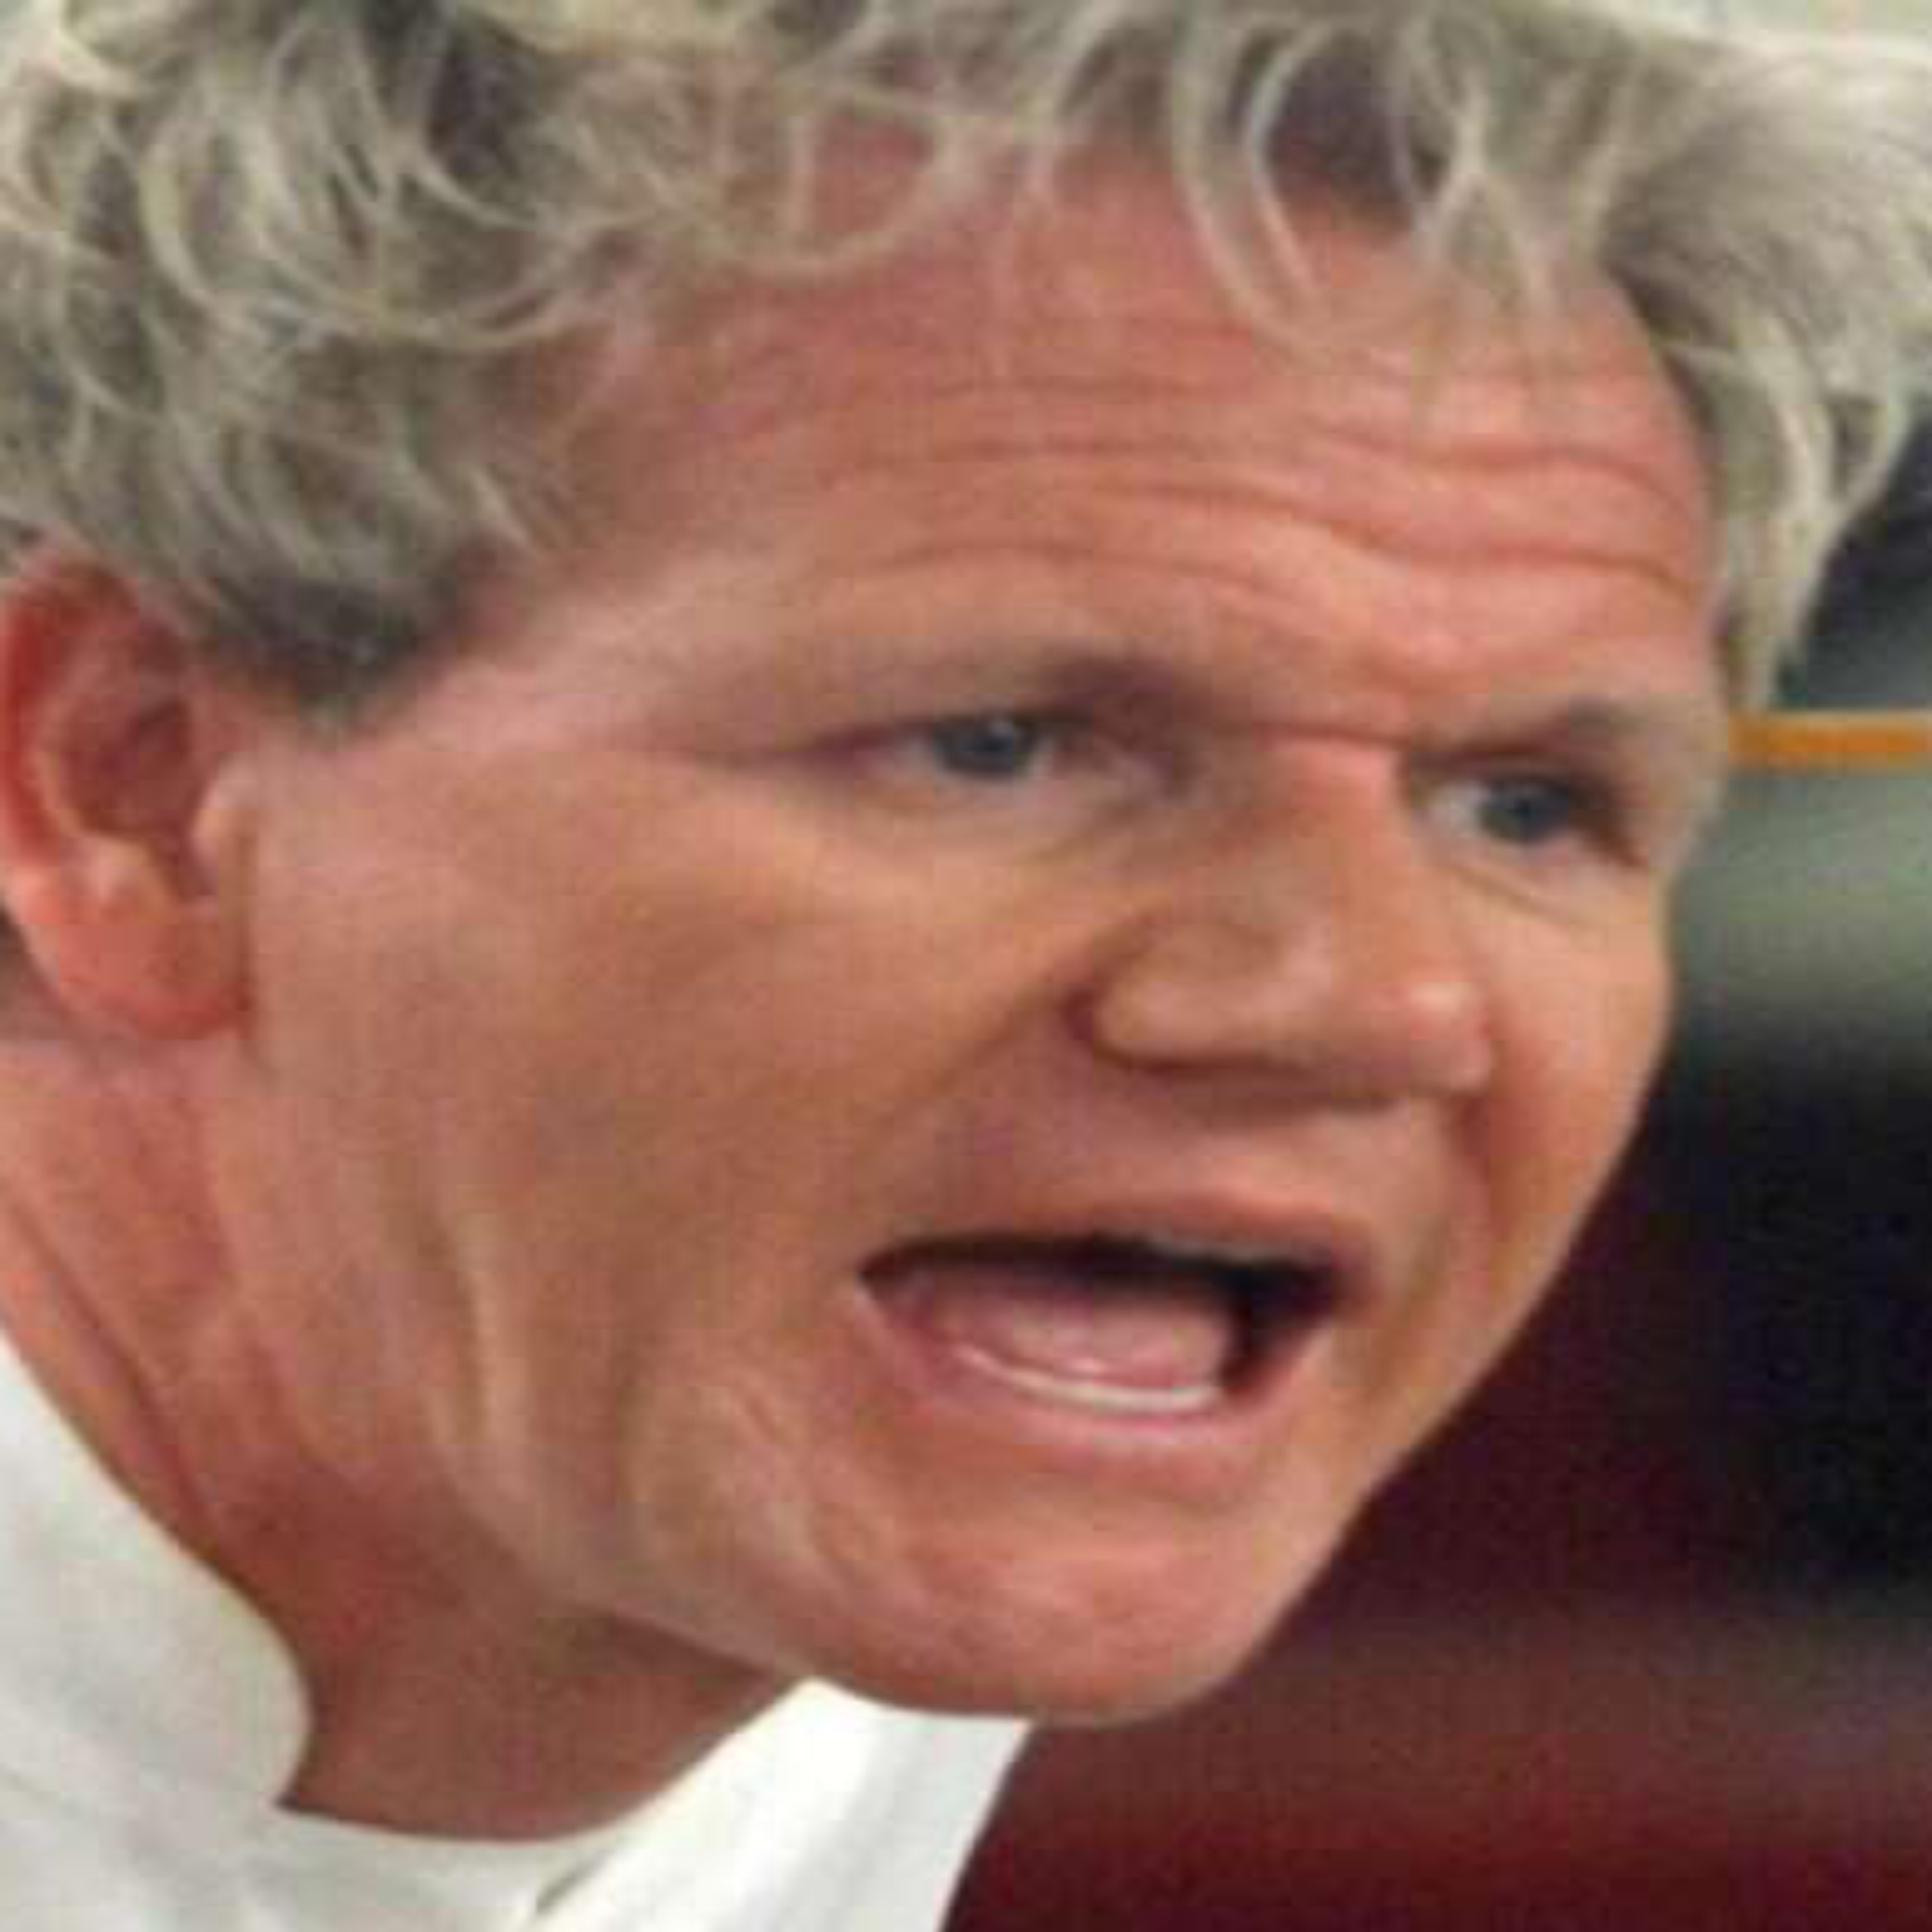

In [16]:
from IPython.display import Image
Image('img1_done.png')